In this notebook the BaMSOO algorithm by *Wang et al. (2014)[1]* is implemented in a simple Python code.

The code is inspired by the MATLAB implementation described in *Al-Dujaili et al. (2016)[2]*."

In [ ]:
import numpy as np
from numpy.linalg import inv, pinv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D

import copy
import pprint
from time import time

from sklearn import datasets, svm
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform
from xgboost import XGBRegressor

## Gaussian process

In [ ]:
def calculateBounds(mu, sigma, N):
    n = 0.1
    #B = np.sqrt(0.01 * np.log(N*N*np.pi*np.pi/(6*n)))
    B = np.sqrt(2 * np.log(N*N*np.pi*np.pi/(6*n)))
    UCB = mu + sigma * B
    LCB = mu - sigma * B
    return UCB, LCB

In [ ]:
def matern5(x, y, theta0, thetai, idx, idx_cat):

  x = [round(val) if i in idx else val for i, val in enumerate(x)]        # round to integer
  y = [round(val) if i in idx else val for i, val in enumerate(y)]

  for sublist in idx_cat:                                                 # "round" to categorical
    max_value = max(x[i] for i in sublist)
    for i in sublist:
      x[i] = 1 if x[i] == max_value else 0

      if x[i] == 1:                                                       #account for multiple x[i] having the same value (=max)
        for j in sublist:
          if j!=i:
            x[j] = 0
      break

  r2 = 0.
  for i in range(len(x)):
    r2 += thetai*(x[i]-y[i])**2
  return theta0*np.exp(-np.sqrt(5*r2))*(1+np.sqrt(5*r2)+5/3*r2)

In [ ]:
def matern_kernel(X1, X2, theta_0, theta_i, idx, idx_cat):
    """
    Matérn kernel function.

    Arguments:
    - X1: Input data matrix 1 of shape (n1, d)
    - X2: Input data matrix 2 of shape (n2, d)

    Returns:
    - K: Kernel matrix of shape (n1, n2)
    """

    X1 = np.array(X1)
    X2 = np.array(X2)

    n1, d = X1.shape
    n2 = X2.shape[0]

    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = matern5(X1[i], X2[j], theta_0, theta_i, idx, idx_cat)
    return K

In [ ]:
def gaussian_process(X_train, Y_train, X_test, theta_0, theta_i, idx, idx_cat):
    """
    Gaussian process regression with Matérn kernel.

    Arguments:
    - X_train: Training input data matrix of shape (n_train, d)
    - Y_train: Training target values vector of shape (n_train,)
    - X_test: Test input data matrix of shape (n_test, d)

    Returns:
    - Y_pred: Predicted target values vector for the test inputs of shape (n_test,)
    - Y_std: Standard deviation vector for the predicted target values of shape (n_test,)
    """

    K_train_train = matern_kernel(X_train, X_train, theta_0, theta_i, idx, idx_cat)
    K_test_train = matern_kernel(X_test, X_train, theta_0, theta_i, idx, idx_cat)
    K_test_test = matern_kernel(X_test, X_test, theta_0, theta_i, idx, idx_cat)

    K1 = pinv(K_train_train)                                                   # inverted ( kernel_matrix+noise )
    A = np.dot(K1,Y_train)

    Y_pred = np.dot(K_test_train,A)

    Y_var = K_test_test - np.dot(K_test_train,np.dot(K1,K_test_train.T))       # variance of the gaussian process
    if Y_var >= 0:
      Y_std = np.sqrt(Y_var)
    else:
      #print(Y_var)
      Y_std = 0

    return Y_pred, Y_std

## Main function

The BaMSOO algorithm combines Gaussian process confidence bounds and treed simultaneous optimistic optimization.
Contrary to the SOO algorithm, BaMSOO does not evaluate the function at each node of the tree instead it uses Gaussian proces (GP) to calculate the upper
and lower bound of the node and only in case of promising results (lower bound smaller than the minimum found so far) proceeds to function evaluation.


We explore different variations of the algorithm, changing the input for the GP and the *eval_gap* condition which refers to the maximum number of new nodes
for which we aren't evaluating the function.

*   **version 1** : (original code) GP updated using only the last 8 samples and *eval_gap* condition remains always verified (which means that when our tree reaches an *eval_gap* number of nodes for which we did not evaluate the function, for every next node we add to the tree we are going to skip the GP and evaluate the function)
*   **version 2** : *eval_gap_counter* that restarts when the *eval_gap* condition is reached
*   **version 3** : no *eval_gap* condition. GP updates are performed using as input only the *sizeX* samples around the node of interest
*   **version 4** : no *eval_gap* condition. GP takes as input all available samples

In [ ]:
def BaMSOO_func(dimension, obj_func, min_range, max_range, num_folds, max_depth, max_f_es, max_num_nodes=100, sample_size=8, plot=False, comparison_plot=False, theta_0=4, theta_i=0.5, IDX=[], IDX_CAT=[], version=2):
  start = time()

  # Function-related
  opts = {
      'ftarget': -np.inf,
      'fitnessFunc': obj_func
        }

  # Algorithm-related
  opts['NUM_DIM'] = dimension                                          # dimensions of the function
  opts['MAX_FES'] = max_f_es                                           # maximum  number of function evaluations
  opts['MAX_RANGE'] = max_range #np.ones(opts['NUM_DIM']) * 1          # upper bound of the function
  opts['MIN_RANGE'] = min_range #np.ones(opts['NUM_DIM']) * 0          # lower bound of the function
  opts['NUM_FOLDS'] = num_folds                                        # number of parts into which each subinterval is divided
  opts['MIDDLE_CELL'] = np.ceil(opts['NUM_FOLDS'] / 2)-1               # half the number of folds
  opts['IS_EVEN_FOLDS'] = (opts['NUM_FOLDS'] % 2) == 0                 # check if the number of folds is even
  opts['INV_NUM_FOLDS'] = 1 / opts['NUM_FOLDS']                        # the inverse of the number of folds
  opts['maxDepthFunc'] = max_depth
  #opts['MAX_NUM_NODES'] = int((opts['NUM_FOLDS'] ** (opts['maxDepthFunc'] + 2) - 1) / (opts['NUM_FOLDS'] - 1))
  opts['MAX_NUM_NODES'] = max_num_nodes                                # maximum number of nodes in tree
  opts['EVAL_GAP'] = 5                                                 # evaluation gap
  opts['showRect'] = True
  opts['IS_VERBOSE'] = (opts['NUM_DIM'] == 2) and opts['showRect']
  opts['SAMPLE_SIZE'] = sample_size                                    # sample size for GP


  # Start the algorithm
  # Calculate the midpoint for each dimension
  midpoint = np.mean([opts['MIN_RANGE'], opts['MAX_RANGE']], axis=0)

  root = {
      'bc': {
          'minX': opts['MIN_RANGE'],
          'maxX': opts['MAX_RANGE']
      },
      'x': midpoint,
      'y': opts['fitnessFunc'](*midpoint)
  }

  opts['xBest'] = root['x']
  opts['yBest'] = root['y']
  opts['numFEs'] = 1
  opts['minDepth'] = 1
  opts['maxDepth'] = 1
  opts['numNodes'] = 1



  # pprint.pprint(opts)
  # pprint.pprint(root)


  sizeX = opts['SAMPLE_SIZE']

  if version == 1 or version == 2:
    X = np.zeros((sizeX, opts['NUM_DIM']))
    y = np.zeros((sizeX, 1))


  elif version == 3 or version == 4 :
    X = np.zeros((opts['MAX_FES'], opts['NUM_DIM']))
    y = np.zeros((opts['MAX_FES'], 1))





  X[0] = root['x']
  y[0] = root['y']
  Xidx = 0
  N = 1

  nodes = {1: [root]}

  flag = False # to brake from multiple loops

  if version ==2:
    eval_gap_counter = 0



#Plot

  if comparison_plot:
    yBest_for_comparison_plot = []

  if plot:

    #color map
    color = iter(cm.rainbow(np.linspace(0, 1, opts['MAX_NUM_NODES'])))
    #color = iter(cm.rainbow(np.linspace(0, 1, 20)))
    c = next(color)

    if dimension == 1:
      x1 = np.linspace(min_range[0], max_range[0],50)
      y1 = np.array([obj_func(i) for i in x1])
      plt.plot(x1, y1, color='gray', lw=1)
      plt.scatter(root['x'], 5, color=c)

      plt.xlabel('x')
      plt.ylabel('objective function', loc='bottom')
      #Legend
      line1 = Line2D([0], [0], color='gray', lw=1, label='Objective function')
      point = Line2D([0], [0], marker='o', markersize=5, linestyle='', c='blue', label='sampled points')
      plt.legend(handles=[line1, point]) #, loc = 'upper left'


    if dimension == 2:
      # Generate x1 and x2 values
      x1 = np.linspace(min_range[0], max_range[0], 100)
      x2 = np.linspace(min_range[1], max_range[1], 100)

      # Create a meshgrid of x1 and x2 values
      X1, X2 = np.meshgrid(x1, x2)

      # Calculate y1 values for each combination of x1 and x2
      Y1 = obj_func(X1, X2)

      # Create a 3D plot
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')

      # Plot the surface
      ax.plot_surface(X1, X2, Y1, cmap='viridis')

      # Set labels and title
      ax.set_xlabel('x1')
      ax.set_ylabel('x2')
      ax.set_zlabel('y')
      ax.set_title('Objective function')

      # Display the plot
      plt.show()


      # Create a 3D figure and axis
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')





  # Main optimization loop
  while True:

      h = opts['minDepth'] - 1
      v = np.inf

      while h <= min(opts['maxDepthFunc'], opts['maxDepth']):
          h += 1
          #print(f"\nh: {h}, nodes: {nodes}")

          if np.size(nodes[h]) == 0:
            if h == min(opts['maxDepthFunc'], opts['maxDepth']):
                break
            else:
                continue

          idx = np.argmin([node['y'] for node in nodes[h]])
          node = nodes[h][idx]

          if v > node['y']:
            v = node['y']
          else:
            if h == min(opts['maxDepthFunc'], opts['maxDepth']):
                break
            else:
                continue

          nodes[h].pop(idx)

          if not nodes[h] and h == opts['minDepth']:
              opts['minDepth'] += 1


          d = (h - 1) % opts['NUM_DIM'] + 1
          r = (node['bc']['maxX'][d - 1] - node['bc']['minX'][d - 1]) * opts['INV_NUM_FOLDS']

          newNodes = [copy.deepcopy(node) for _ in range(opts['NUM_FOLDS'])]
          opts['maxDepth'] = max(opts['maxDepth'], h)

          #print('\n newnodes:',newNodes)

          for f in range(opts['NUM_FOLDS']):
              isEvaluated = False
              opts['numNodes'] += 1

              newNodes[f]['bc']['minX'] = node['bc']['minX'].copy()
              newNodes[f]['bc']['maxX'] = node['bc']['maxX'].copy()

              newNodes[f]['bc']['minX'][d - 1] += r * f
              newNodes[f]['bc']['maxX'][d - 1] = newNodes[f]['bc']['minX'][d - 1] + r

              #newNodes[f]['x'] = np.mean([newNodes[f]['bc']['minX'], newNodes[f]['bc']['maxX']], axis=0)


              if f == opts['MIDDLE_CELL'] and not opts['IS_EVEN_FOLDS']:
                  newNodes[f]['x'] = node['x']
                  newNodes[f]['y'] = node['y']
              else:
                  newNodes[f]['x'] = np.mean([newNodes[f]['bc']['minX'], newNodes[f]['bc']['maxX']], axis=0)

                  if opts['numFEs'] <= sizeX:
                      newNodes[f]['y'] = opts['fitnessFunc'](*newNodes[f]['x'])
                      isEvaluated = True
                      X[Xidx] = newNodes[f]['x']
                      y[Xidx] = newNodes[f]['y']

                      if version==1 or version==2:
                        Xidx = (Xidx + 1) % sizeX
                      if version==3 or version==4:
                        Xidx = Xidx + 1



                  else:
                      N += 1

                      #Gaussian process
                      if version==3:

                        X_samples = X[:Xidx]
                        y_samples = y[:Xidx]
                        samples = np.column_stack((X_samples, y_samples.reshape(1,y_samples.shape[0])[0]))

                        dist = [np.linalg.norm(i[0]-np.array(newNodes[f]['x'][0])) for i in X[:Xidx]] #distance from node
                        samples = np.column_stack((samples, np.array(dist)))

                        samples = samples[samples[:, opts['NUM_DIM']+1].argsort()] #sort
                        samples = samples[:sizeX] # take the closest sizeX samples

                        mu, sigma = gaussian_process(samples[:,:opts['NUM_DIM']], samples[:, opts['NUM_DIM']], np.array(newNodes[f]['x']).reshape(1, opts['NUM_DIM']), theta_0=theta_0, theta_i=theta_i, idx=IDX, idx_cat=IDX_CAT)

                      elif version==4:
                        X_samples = X[:Xidx]
                        y_samples = y[:Xidx]
                        mu, sigma = gaussian_process(X_samples, y_samples.reshape(1, y_samples.shape[0])[0], np.array(newNodes[f]['x']).reshape(1, opts['NUM_DIM']), theta_0=theta_0, theta_i=theta_i, idx=IDX, idx_cat=IDX_CAT)


                      else:
                        mu, sigma = gaussian_process(X, y.reshape(1, y.shape[0])[0], np.array(newNodes[f]['x']).reshape(1, opts['NUM_DIM']), theta_0=theta_0, theta_i=theta_i, idx=IDX, idx_cat=IDX_CAT)


                      UCB, LCB = calculateBounds(mu, sigma, N)


                      if version == 1:
                        if LCB <= opts['yBest'] or (opts['numNodes'] - opts['numFEs']) > opts['EVAL_GAP']:
                            newNodes[f]['y'] = opts['fitnessFunc'](*newNodes[f]['x'])
                            isEvaluated = True

                            X[Xidx] = newNodes[f]['x'] # ----> tolto + 1
                            y[Xidx] = newNodes[f]['y']
                            Xidx = (Xidx + 1) % sizeX

                            # print("\nx = ", newNodes[f]['x'])
                            # print("y = ", opts['fitnessFunc'](*newNodes[f]['x']))
                            # print("opts['yBest'] = ", opts['yBest'])
                            # print("UCB = ", UCB)
                            # print("LCB = ", LCB)
                            # print("mu = ", mu)
                            # print("sigma = ", sigma)

                        else:
                            newNodes[f]['y'] = UCB


                      if version == 2:
                        if LCB <= opts['yBest'] or eval_gap_counter > opts['EVAL_GAP']:

                            if eval_gap_counter > opts['EVAL_GAP']:
                              eval_gap_counter = 0

                            newNodes[f]['y'] = opts['fitnessFunc'](*newNodes[f]['x'])
                            isEvaluated = True

                            X[Xidx] = newNodes[f]['x'] # ----> tolto + 1
                            y[Xidx] = newNodes[f]['y']
                            Xidx = (Xidx + 1) % sizeX
                        else:
                            newNodes[f]['y'] = UCB
                            eval_gap_counter +=1


                      if version == 3 or version == 4:
                        if LCB <= opts['yBest']:
                            newNodes[f]['y'] = opts['fitnessFunc'](*newNodes[f]['x'])
                            isEvaluated = True

                            X[Xidx] = newNodes[f]['x']
                            y[Xidx] = newNodes[f]['y']
                            Xidx = Xidx + 1
                        else:
                            newNodes[f]['y'] = UCB



              #Plot
              if plot:
                if dimension == 2:
                  # Scatter plot
                  ax.scatter(*newNodes[f]['x'], 5 - 0.5 * h, color=c, marker='o')
                  c = next(color)

                  # Set labels and title
                  ax.set_xlabel('x1')
                  ax.set_ylabel('x2')
                  ax.set_zlabel('y')
                  ax.set_title('3D Tree Visualization')

                if dimension==1:
                  plt.scatter(newNodes[f]['x'], 5 - 0.5 * h, marker='.', color=c)
                  c = next(color)


              if opts['yBest'] > newNodes[f]['y'] and isEvaluated:
                  opts['yBest'] = newNodes[f]['y']
                  opts['xBest'] = newNodes[f]['x']

                  if opts['yBest'] < opts['ftarget']:
                      yBest = opts['yBest']
                      xBest = opts['xBest']
                      flag = True
                      print("Target value reached")
                      break


              if isEvaluated:
                  opts['numFEs'] += 1
                  if comparison_plot:
                    yBest_for_comparison_plot.append(-opts['yBest'])

                  if opts['numFEs'] >= opts['MAX_FES']:
                      yBest = opts['yBest']
                      xBest = opts['xBest']
                      flag = True
                      print("\nMaximum number of function evaluation is reached")
                      break


              if opts['numNodes'] >= opts['MAX_NUM_NODES']:
                  print('The tree of depth', opts['maxDepthFunc'], 'has been fully explored with', opts['numNodes'], 'nodes!')
                  yBest = opts['yBest']
                  xBest = opts['xBest']
                  flag = True
                  break


          if flag:
            break

          # add the children nodes
          if h + 1 in nodes:
              nodes[h + 1].extend(newNodes)
          else:
              nodes[h + 1] = newNodes



      if flag:
          end = time()
          print("\n---------------------------------------------------------------------------------------------------------------------------------")
          print("version ",version)
          print("\nmin:\tx =", xBest)
          print("\ty =", yBest)
          print('Number of nodes in tree: ', opts['numNodes'])
          print('Number of function evaluations: ', opts['numFEs'])
          print('Max depth reached: ', opts['maxDepth'])
          print('Min depth reached: ', opts['minDepth'])
          print("Execution time: ", end-start)

          if comparison_plot:
            return yBest_for_comparison_plot
          else:
            break

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# 1D

In [ ]:
def objective_func_1d(x):
      return 0.5 * (np.sin(23 * (x - 0.1)) * np.sin(27 * x)) + 0.5 + 0.7 * (np.abs(x - 0.4)) ** 0.5

### version 1


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  1

min:	x = [0.41769547]
	y = 0.18296120074807304
Number of nodes in tree:  46
Number of function evaluations:  30
Max depth reached:  6
Min depth reached:  3
Execution time:  0.19676947593688965


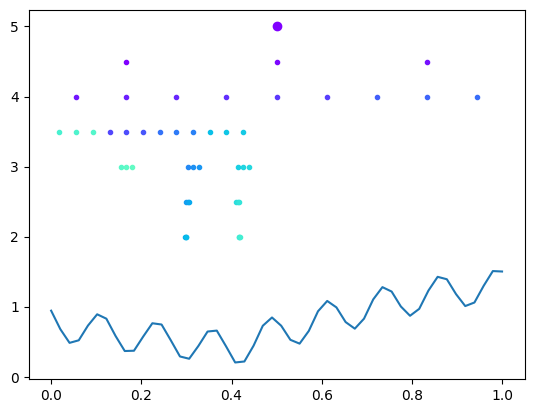

In [ ]:
BaMSOO_func(1, objective_func_1d, min_range=[0.0], max_range=[1.0], num_folds=3, max_depth=10, max_f_es=30, plot =True)

### version 2


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.41982929]
	y = 0.18440029285482692
Number of nodes in tree:  46
Number of function evaluations:  20
Max depth reached:  8
Min depth reached:  3
Execution time:  0.1785874366760254


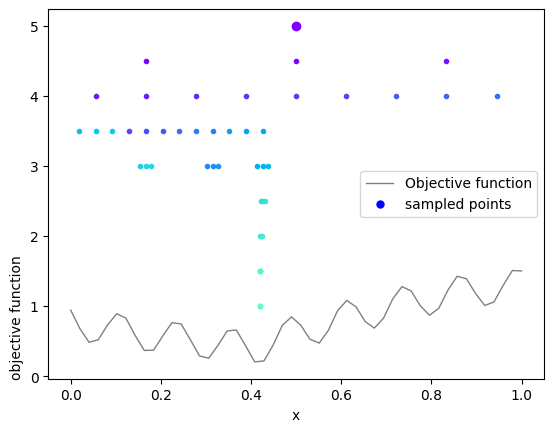

In [ ]:
BaMSOO_func(1, objective_func_1d, min_range=[0.0], max_range=[1.0], num_folds=3, max_depth=10, max_f_es=20, plot =True, version=2)

### version 3


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  3

min:	x = [0.41982929]
	y = 0.18440029285482692
Number of nodes in tree:  50
Number of function evaluations:  20
Max depth reached:  8
Min depth reached:  3
Execution time:  0.14451384544372559


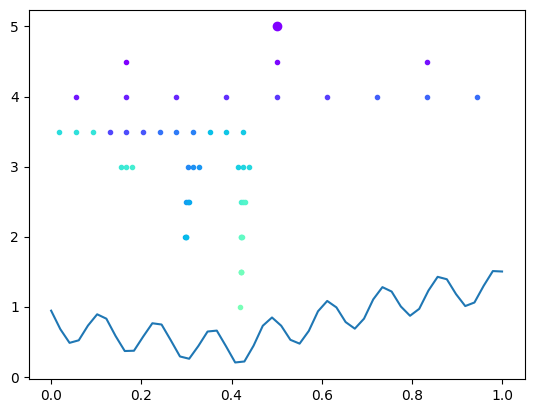

In [ ]:
BaMSOO_func(1, objective_func_1d, min_range=[0.0], max_range=[1.0], num_folds=3, max_depth=10, max_f_es=20, plot =True, version=3)

### version 4


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  4

min:	x = [0.41982929]
	y = 0.18440029285482692
Number of nodes in tree:  50
Number of function evaluations:  20
Max depth reached:  8
Min depth reached:  3
Execution time:  0.25288867950439453


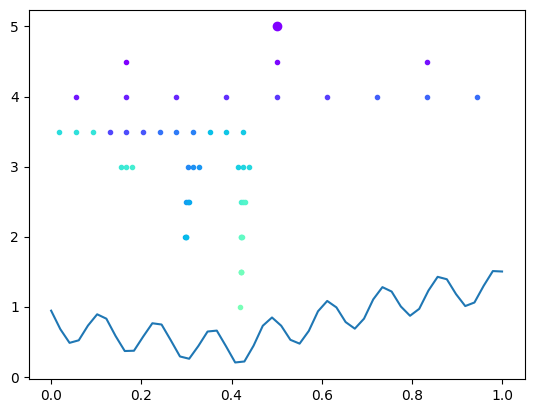

In [ ]:
BaMSOO_func(1, objective_func_1d, min_range=[0.0], max_range=[1.0], num_folds=3, max_depth=10, max_f_es=20, plot =True, version=4)

# 2D

In [ ]:
def objective_func_2d(x1, x2):
      return np.exp(-(x1 + x2)**2) + 1*np.sin(x1/8) + 0.05*np.cos(12*x2)

### version 1

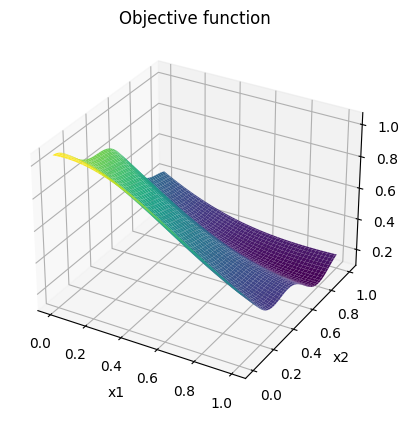


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  1

min:	x = [0.98148148 0.7962963 ]
	y = 0.11520940326436652
Number of nodes in tree:  29
Number of function evaluations:  20
Max depth reached:  7
Min depth reached:  2
Execution time:  0.843097448348999


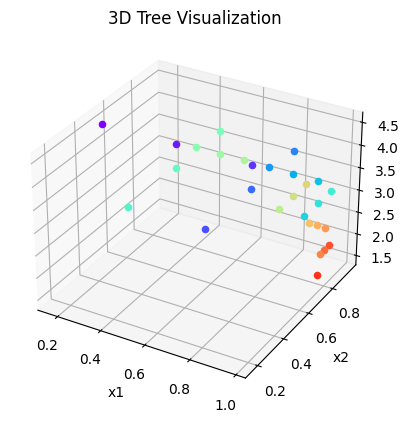

In [ ]:
BaMSOO_func(2, objective_func_2d, min_range=[0.0, 0.0], max_range=[1.0, 1.0], num_folds=3, max_depth=6, max_f_es=20, plot =True, version=1)

### version 2

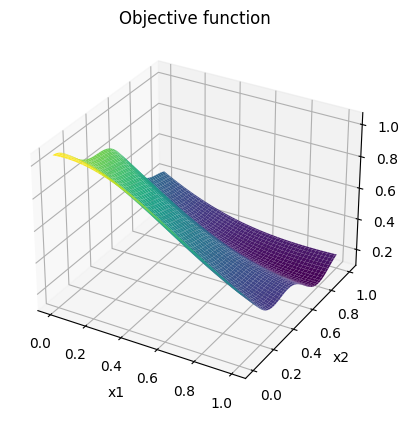


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.98148148 0.7962963 ]
	y = 0.11520940326436652
Number of nodes in tree:  29
Number of function evaluations:  20
Max depth reached:  7
Min depth reached:  2
Execution time:  0.979954719543457


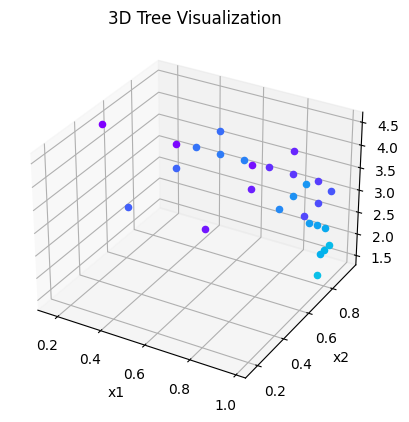

In [ ]:
BaMSOO_func(2, objective_func_2d, min_range=[0.0, 0.0], max_range=[1.0, 1.0], num_folds=3, max_depth=10, max_f_es=20, plot =True, version=2)

### version 3

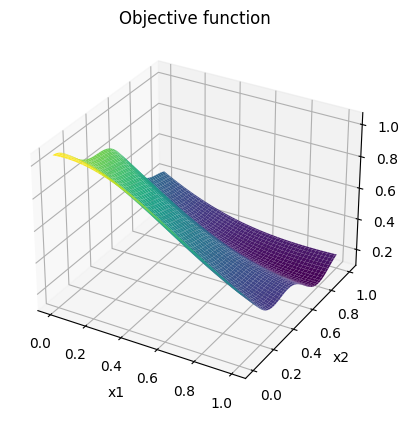


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  3

min:	x = [0.98148148 0.7962963 ]
	y = 0.11520940326436652
Number of nodes in tree:  29
Number of function evaluations:  20
Max depth reached:  7
Min depth reached:  2
Execution time:  1.2925901412963867


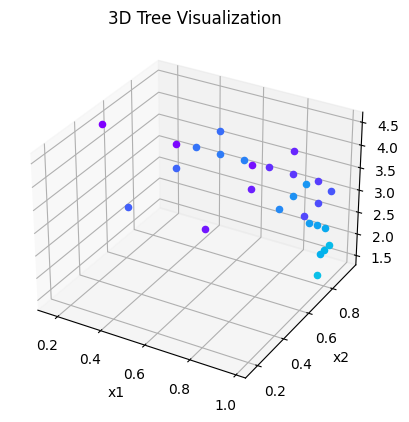

In [ ]:
BaMSOO_func(2, objective_func_2d, min_range=[0.0, 0.0], max_range=[1.0, 1.0], num_folds=3, max_depth=10, max_f_es=20, plot =True, version=3)

### version 4

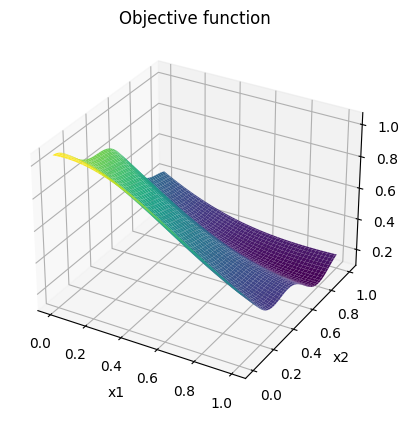


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  4

min:	x = [0.98148148 0.7962963 ]
	y = 0.11520940326436652
Number of nodes in tree:  29
Number of function evaluations:  20
Max depth reached:  7
Min depth reached:  2
Execution time:  0.7919766902923584


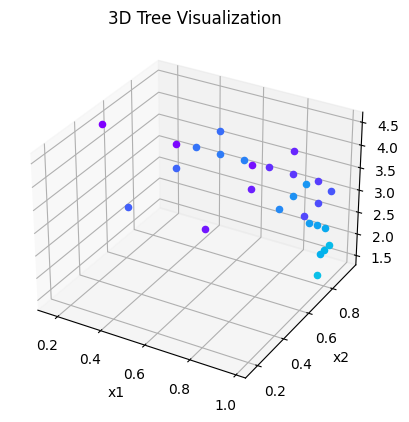

In [ ]:
BaMSOO_func(2, objective_func_2d, min_range=[0.0, 0.0], max_range=[1.0, 1.0], num_folds=3, max_depth=10, max_f_es=20, plot =True, version=4)

# XGBoost

In [ ]:
# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor()

# and compute a baseline to beat with hyperparameter optimization
baseline = cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()

In [ ]:
print(baseline)

-4216.24235430438


In [ ]:
# bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
#         {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
#         {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
#         {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
#         {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

### 1 parameter

In [ ]:
def cv_score(par1):
    score = cross_val_score(
                XGBRegressor(learning_rate=par1),
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(-score)
    return score

#### Tests on different versions

In [ ]:
BaMSOO_func(1, cv_score, min_range=[0.0], max_range=[1.0], num_folds=3, max_depth=10, max_f_es=20, max_num_nodes=100, version=1)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  1

min:	x = [0.04320988]
	y = 3816.697864503204
Number of nodes in tree:  31
Number of function evaluations:  20
Max depth reached:  5
Min depth reached:  3
Execution time:  11.022039651870728


In [ ]:
BaMSOO_func(1, cv_score, min_range=[0.0], max_range=[1.0], num_folds=3, max_depth=10, max_f_es=20, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.06241427]
	y = 3847.0092517171847
Number of nodes in tree:  59
Number of function evaluations:  20
Max depth reached:  7
Min depth reached:  3
Execution time:  10.811642408370972


In [ ]:
BaMSOO_func(1, cv_score, min_range=[0.0], max_range=[1.0], num_folds=5, max_depth=10, max_f_es=20, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.0568]
	y = 3847.677184086106
Number of nodes in tree:  42
Number of function evaluations:  20
Max depth reached:  5
Min depth reached:  2
Execution time:  8.425825834274292


In [ ]:
BaMSOO_func(1, cv_score, min_range=[0.0], max_range=[1.0], num_folds=10, max_depth=10, max_f_es=20, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.225]
	y = 3847.545216791911
Number of nodes in tree:  62
Number of function evaluations:  20
Max depth reached:  4
Min depth reached:  2
Execution time:  10.285514116287231


In [ ]:
BaMSOO_func(1, cv_score, min_range=[0.0], max_range=[1.0], num_folds=3, max_depth=10, max_f_es=20, max_num_nodes=100, version=3)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  3

min:	x = [0.1872428]
	y = 3845.12348578519
Number of nodes in tree:  74
Number of function evaluations:  20
Max depth reached:  7
Min depth reached:  3
Execution time:  10.27598524093628


In [ ]:
BaMSOO_func(1, cv_score, min_range=[0.0], max_range=[1.0], num_folds=3, max_depth=10, max_f_es=20, max_num_nodes=100, version=4)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  4

min:	x = [0.1872428]
	y = 3845.12348578519
Number of nodes in tree:  71
Number of function evaluations:  20
Max depth reached:  7
Min depth reached:  3
Execution time:  10.344305276870728


#### RandomizedSearch for comparison

In [ ]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1)}


rs = RandomizedSearchCV(xgb, param_distributions=param_dist,
                        scoring='neg_mean_squared_error', n_iter=20)

# Run random search for 20 iterations
start = time()
rs.fit(X, Y)
end = time()

print("time: ", end-start)
print("score: ", rs.best_score_)
print("par: ", rs.best_params_)

time:  10.07503890991211
score:  -3909.5858279790145
par:  {'learning_rate': 0.1750501196063764}


### 2 parameters

In [ ]:
def cv_score(par1, par2):
    score = cross_val_score(
                XGBRegressor(learning_rate=par1,
                             gamma=par2),
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(-score)
    return score

#### Tests on different versions

In [ ]:
BaMSOO_func(2, cv_score, min_range=[0.0, 0.0], max_range=[1.0, 5.0], num_folds=3, max_depth=10, max_f_es=20, max_num_nodes=100, version=1)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  1

min:	x = [0.05555556 1.94444444]
	y = 3906.181289053082
Number of nodes in tree:  29
Number of function evaluations:  20
Max depth reached:  5
Min depth reached:  3
Execution time:  11.031082391738892


In [ ]:
BaMSOO_func(2, cv_score, min_range=[0.0, 0.0], max_range=[1.0, 5.0], num_folds=3, max_depth=10, max_f_es=20, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.05555556 1.94444444]
	y = 3906.181289053082
Number of nodes in tree:  29
Number of function evaluations:  20
Max depth reached:  5
Min depth reached:  3
Execution time:  11.587392807006836


In [ ]:
BaMSOO_func(2, cv_score, min_range=[0.0, 0.0], max_range=[1.0, 5.0], num_folds=5, max_depth=5, max_f_es=20, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.1 3.7]
	y = 3870.149147778452
Number of nodes in tree:  32
Number of function evaluations:  20
Max depth reached:  5
Min depth reached:  2
Execution time:  20.45326066017151


In [ ]:
BaMSOO_func(2, cv_score, min_range=[0.0, 0.0], max_range=[1.0, 5.0], num_folds=5, max_depth=10, max_f_es=20, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.1 3.7]
	y = 3870.149147778452
Number of nodes in tree:  32
Number of function evaluations:  20
Max depth reached:  5
Min depth reached:  2
Execution time:  10.283076763153076


In [ ]:
BaMSOO_func(2, cv_score, min_range=[0.0, 0.0], max_range=[1.0, 5.0], num_folds=10, max_depth=10, max_f_es=20, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.05 4.75]
	y = 3889.2259863266345
Number of nodes in tree:  22
Number of function evaluations:  20
Max depth reached:  3
Min depth reached:  2
Execution time:  35.80431246757507


In [ ]:
BaMSOO_func(2, cv_score, min_range=[0.0, 0.0], max_range=[1.0, 5.0], num_folds=3, max_depth=10, max_f_es=20, max_num_nodes=100, version=3)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  3

min:	x = [0.05555556 1.94444444]
	y = 3906.181289053082
Number of nodes in tree:  32
Number of function evaluations:  20
Max depth reached:  5
Min depth reached:  3
Execution time:  22.843666076660156


In [ ]:
BaMSOO_func(2, cv_score, min_range=[0.0, 0.0], max_range=[1.0, 5.0], num_folds=3, max_depth=10, max_f_es=20, max_num_nodes=100, version=4)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  4

min:	x = [0.05555556 1.94444444]
	y = 3906.181289053082
Number of nodes in tree:  32
Number of function evaluations:  20
Max depth reached:  5
Min depth reached:  3
Execution time:  38.13882827758789


#### RandomizedSearch for comparison

In [ ]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5)}


rs = RandomizedSearchCV(xgb, param_distributions=param_dist,
                        scoring='neg_mean_squared_error', n_iter=20)

# Run random search for 20 iterations
start = time()
rs.fit(X, Y)
end = time()

print("time: ", end-start)
print("score: ", rs.best_score_)
print("par: ", rs.best_params_)

time:  26.883975982666016
score:  -3886.97028557123
par:  {'gamma': 4.92513793533715, 'learning_rate': 0.13043677626867334}


### 3 parameters

In [ ]:
def cv_score(par1, par2, par3):
    score = cross_val_score(
                XGBRegressor(learning_rate=par1,
                             gamma=par2,
                             min_child_weight = int(par3)),
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(-score)
    return score

#### Tests on different versions

In [ ]:
BaMSOO_func(3, cv_score, min_range=[0.0, 0.0, 1], max_range=[1.0, 5.0, 10], num_folds=3, max_depth=10, max_f_es=30, max_num_nodes=100, version=1)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  1

min:	x = [0.05555556 4.72222222 9.5       ]
	y = 3475.1459449332397
Number of nodes in tree:  44
Number of function evaluations:  30
Max depth reached:  7
Min depth reached:  3
Execution time:  13.00001072883606


In [ ]:
BaMSOO_func(3, cv_score, min_range=[0.0, 0.0, 1], max_range=[1.0, 5.0, 10], num_folds=3, max_depth=10, max_f_es=30, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.05555556 4.72222222 9.5       ]
	y = 3475.1459449332397
Number of nodes in tree:  50
Number of function evaluations:  30
Max depth reached:  7
Min depth reached:  3
Execution time:  12.908876180648804


In [ ]:
BaMSOO_func(3, cv_score, min_range=[0.0, 0.0, 1], max_range=[1.0, 5.0, 10], num_folds=3, max_depth=5, max_f_es=30, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.05555556 4.72222222 9.5       ]
	y = 3475.1459449332397
Number of nodes in tree:  53
Number of function evaluations:  30
Max depth reached:  6
Min depth reached:  3
Execution time:  12.971934795379639


In [ ]:
BaMSOO_func(3, cv_score, min_range=[0.0, 0.0, 1], max_range=[1.0, 5.0, 10], num_folds=5, max_depth=10, max_f_es=30, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.1 2.5 9.1]
	y = 3612.449084969691
Number of nodes in tree:  42
Number of function evaluations:  30
Max depth reached:  4
Min depth reached:  2
Execution time:  13.10672402381897


In [ ]:
BaMSOO_func(3, cv_score, min_range=[0.0, 0.0, 1], max_range=[1.0, 5.0, 10], num_folds=10, max_depth=10, max_f_es=30, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.05 0.25 9.55]
	y = 3498.856217212876
Number of nodes in tree:  36
Number of function evaluations:  30
Max depth reached:  4
Min depth reached:  2
Execution time:  14.117006301879883


In [ ]:
BaMSOO_func(3, cv_score, min_range=[0.0, 0.0, 1], max_range=[1.0, 5.0, 10], num_folds=3, max_depth=10, max_f_es=30, max_num_nodes=100, version=3)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  3

min:	x = [0.05555556 4.72222222 9.5       ]
	y = 3475.1459449332397
Number of nodes in tree:  47
Number of function evaluations:  30
Max depth reached:  7
Min depth reached:  3
Execution time:  14.926755428314209


In [ ]:
BaMSOO_func(3, cv_score, min_range=[0.0, 0.0, 1], max_range=[1.0, 5.0, 10], num_folds=3, max_depth=10, max_f_es=30, max_num_nodes=100, version=4)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  4

min:	x = [0.05555556 4.72222222 9.5       ]
	y = 3475.1459449332397
Number of nodes in tree:  50
Number of function evaluations:  30
Max depth reached:  7
Min depth reached:  3
Execution time:  14.059298276901245


#### RandomizedSearch for comparison

In [ ]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50)}


rs = RandomizedSearchCV(xgb, param_distributions=param_dist,
                        scoring='neg_mean_squared_error', n_iter=30)

# Run random search for 30 iterations
start = time()
rs.fit(X, Y)
end = time()

print("time: ", end-start)
print("score: ", rs.best_score_)
print("par: ", rs.best_params_)

time:  33.67865037918091
score:  -3856.4661426938255
par:  {'gamma': 4.386532459894131, 'learning_rate': 0.9998278015632831, 'max_depth': 1}


### 4 parameters

In [ ]:
def cv_score(par1, par2, par3, par4):
    score = cross_val_score(
                XGBRegressor(learning_rate=par1,
                             gamma=par2,
                             min_child_weight = int(par3),
                             max_depth = int(par4)
                             #n_estimators: int(par5),
                             ),
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(-score)
    return score

#### Tests on different versions

In [ ]:
BaMSOO_func(4, cv_score, min_range=[0.0, 0.0, 1, 1], max_range=[1.0, 5.0, 10, 50], num_folds=3, max_depth=10, max_f_es=40, max_num_nodes=100, version=1)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  1

min:	x = [ 0.16666667  0.27777778  5.5        41.83333333]
	y = 3699.121260932049
Number of nodes in tree:  59
Number of function evaluations:  40
Max depth reached:  8
Min depth reached:  3
Execution time:  36.28543043136597


In [ ]:
BaMSOO_func(4, cv_score, min_range=[0.0, 0.0, 1, 1], max_range=[1.0, 5.0, 10, 50], num_folds=3, max_depth=10, max_f_es=40, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [ 0.16666667  0.27777778  5.5        41.83333333]
	y = 3699.121260932049
Number of nodes in tree:  61
Number of function evaluations:  40
Max depth reached:  8
Min depth reached:  3
Execution time:  37.818849325180054


In [ ]:
BaMSOO_func(4, cv_score, min_range=[0.0, 0.0, 1, 1], max_range=[1.0, 5.0, 10, 50], num_folds=5, max_depth=10, max_f_es=40, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [ 0.1  1.5  5.5 15.7]
	y = 3702.177730620953
Number of nodes in tree:  52
Number of function evaluations:  40
Max depth reached:  5
Min depth reached:  2
Execution time:  62.02301549911499


In [ ]:
BaMSOO_func(4, cv_score, min_range=[0.0, 0.0, 1, 1], max_range=[1.0, 5.0, 10, 50], num_folds=10, max_depth=10, max_f_es=40, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.05 1.75 9.55 3.45]
	y = 3245.8216363056545
Number of nodes in tree:  42
Number of function evaluations:  40
Max depth reached:  5
Min depth reached:  2
Execution time:  29.15168070793152


In [ ]:
BaMSOO_func(4, cv_score, min_range=[0.0, 0.0, 1, 1], max_range=[1.0, 5.0, 10, 50], num_folds=10, max_depth=3, max_f_es=40, max_num_nodes=100, version=2)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [0.05 1.75 9.55 3.45]
	y = 3245.8216363056545
Number of nodes in tree:  42
Number of function evaluations:  40
Max depth reached:  4
Min depth reached:  2
Execution time:  32.85700964927673


In [ ]:
BaMSOO_func(4, cv_score, min_range=[0.0, 0.0, 1, 1], max_range=[1.0, 5.0, 10, 50], num_folds=3, max_depth=10, max_f_es=40, max_num_nodes=100, version=3)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  3

min:	x = [ 0.16666667  0.27777778  5.5        41.83333333]
	y = 3699.121260932049
Number of nodes in tree:  59
Number of function evaluations:  40
Max depth reached:  8
Min depth reached:  3
Execution time:  38.372045278549194


In [ ]:
BaMSOO_func(4, cv_score, min_range=[0.0, 0.0, 1, 1], max_range=[1.0, 5.0, 10, 50], num_folds=3, max_depth=10, max_f_es=40, max_num_nodes=100, version=4)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  4

min:	x = [ 0.16666667  0.27777778  5.5        41.83333333]
	y = 3699.121260932049
Number of nodes in tree:  61
Number of function evaluations:  40
Max depth reached:  8
Min depth reached:  3
Execution time:  38.37124538421631


#### RandomizedSearch for comparison

In [ ]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}


rs = RandomizedSearchCV(xgb, param_distributions=param_dist,
                        scoring='neg_mean_squared_error', n_iter=40)

# Run random search for 40 iterations
start = time()
rs.fit(X, Y)
end = time()

print("time: ", end-start)
print("score: ", rs.best_score_)
print("par: ", rs.best_params_)

time:  53.6020085811615
score:  -3436.168429658827
par:  {'gamma': 0.9455570208390363, 'learning_rate': 0.6665978769791095, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 45}


### Results
Comparison between BaMSOO and Random serach at the same number of function evaluations

|                      |  No par | execution time | score  | func eval |
|----------------------|---------|----------------|--------|-----|
| BaMSOO (v2)          | 1       |       8.4      | 3847.7 | 20
| RS                   | 1       |       9.9      | 3868.4 | 20
| BaMSOO (v2)          | 2       |      11.6      | 3906.2 | 20
| RS                   | 2       |      26.8      | 3887   | 20
| BaMSOO (v2)          | 3       |      13.1      | 3612.4 | 30
| RS                   | 3       |      32.5      | 3985.5 | 30
| BaMSOO (v2)          | 4       |      37.8      | 3699.1 | 40
| RS                   | 4       |      41.5      | 3496.6 | 40

# Data: Kuzushiji-MNIST dataset

In [ ]:
!git clone https://github.com/Filorland/Information-Theory-and-Inference.git

Cloning into 'Information-Theory-and-Inference'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 19 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (19/19), 17.36 MiB | 13.78 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# helper function to load Kuzushiji-MNIST dataset
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

In [ ]:
#fix your ID ("numero di matricola") and the seed for random generator (as usual you can try different seeds)
ID = 1122632
np.random.seed(ID)

#load the K-MNIST dataset from the 'data' folder and let's normalize the features so that each value is in [0,1]

X, y = load_mnist('/content/Information-Theory-and-Inference/SVM/data', kind='train')
# rescale the data
X, y = X / 255., y # original pixel values are between 0 and 255
print(X.shape, y.shape)

# Random permute the data and split into training and test taking the first 600
# data samples as training and 4000 samples as test
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

(60000, 784) (60000,)
Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [63 66 61 68 55 55 59 62 60 51]


# SVM

## 2 hyperparameters (2d)

In [ ]:
def ML(C , gamma):
  #C , gamma = par
  clf = svm.SVC(C = C, gamma = gamma)
  clf.fit(X_train, y_train)
  a = clf.score(X_test, y_test, sample_weight=None) #clf.score(X_train, y_train, sample_weight=None)
  return -a

In [ ]:
y_svm2 = BaMSOO_func(2, ML, min_range=[0.1, 0.001], max_range=[10.0, 1.0], num_folds=6, max_depth=10, max_f_es=51, max_num_nodes=100, version=2, theta_0=4, theta_i=0.5, comparison_plot=True)

The tree of depth 10 has been fully explored with 100 nodes!

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [1.45208333 0.014875  ]
	y = -0.824
Number of nodes in tree:  100
Number of function evaluations:  49
Max depth reached:  7
Min depth reached:  2
Execution time:  91.11016511917114


#### Tests with different versions

In [ ]:
BaMSOO_func(2, ML, min_range=[0.1, 0.001], max_range=[10.0, 1.0], num_folds=6, max_depth=10, max_f_es=51, max_num_nodes=100, version=1, comparison_plot=True)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  1

min:	x = [1.45208333 0.014875  ]
	y = -0.824
Number of nodes in tree:  56
Number of function evaluations:  51
Max depth reached:  6
Min depth reached:  2
Execution time:  114.04897618293762


In [ ]:
BaMSOO_func(2, ML, min_range=[0.1, 0.001], max_range=[10.0, 1.0], num_folds=6, max_depth=10, max_f_es=51, max_num_nodes=100, version=3, comparison_plot=True)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  3

min:	x = [1.45208333 0.014875  ]
	y = -0.824
Number of nodes in tree:  71
Number of function evaluations:  51
Max depth reached:  6
Min depth reached:  2
Execution time:  96.7785382270813


In [ ]:
BaMSOO_func(2, ML, min_range=[0.1, 0.001], max_range=[10.0, 1.0], num_folds=6, max_depth=10, max_f_es=51, max_num_nodes=100, version=4, comparison_plot=True)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  4

min:	x = [1.45208333 0.014875  ]
	y = -0.824
Number of nodes in tree:  71
Number of function evaluations:  51
Max depth reached:  6
Min depth reached:  2
Execution time:  87.73378014564514


#### Plot

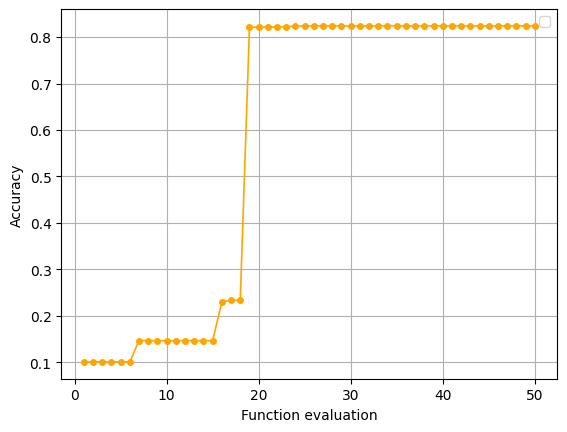

In [ ]:
Niter=50
r = range(1, Niter+1)
plt.plot(r, y_svm2, marker = 'o', linewidth=1.2, color='orange', markersize=4)

plt.xlabel('Function evaluation')
plt.ylabel('Accuracy')

plt.grid()
plt.legend()

## SVM with categorical data (4 hyperparameters, 5d)

In [ ]:
def SVM_4D(par1, par2, par3, par4, par5):
  par = np.array([par1, par2, par3, par4, par5])
  idx=[0]
  idx_cat = [[3, 4]]

  par = [round(val) if i in idx else val for i, val in enumerate(par)]          # round to integer

  for sublist in idx_cat:                                                       # "round" to categorical
    max_value = max(par[i] for i in sublist)
    for i in range(len(par)):
        if i in sublist:
            par[i] = 1 if par[i] == max_value else 0

  degree, C, gamma, *kernel = par

  ker = {0: 'rbf', 1: 'poly'}                                                   # convert categorical variables to the SVM parameter

  index = kernel.index(1)
  kernel = ker.get(index)

  clf = svm.SVC(degree = round(degree), gamma = gamma, C = C, kernel = kernel)
  clf.fit(X_train, y_train)
  a = clf.score(X_test, y_test, sample_weight=None)

  return -a

In [ ]:
idx=[0]
idx_cat=[[3, 4]]
bounds_par = [(0,4), (0.1, 10.), (0.001, 1.), (0.,1.), (0.,1.)]
min_range=[0, 0.1, 0.001, 0., 0.]
max_range=[4, 10., 1., 1., 1.]

In [ ]:
y_svm4 = BaMSOO_func(5, SVM_4D, min_range=min_range, max_range=max_range, num_folds=3, max_depth=10, max_f_es=51, max_num_nodes=100, version=2, IDX=[0], IDX_CAT=[[3, 4]],  comparison_plot=True)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [2.         1.75       0.1675     0.16666667 0.83333333]
	y = -0.7905
Number of nodes in tree:  100
Number of function evaluations:  51
Max depth reached:  7
Min depth reached:  3
Execution time:  73.81240391731262


In [ ]:
print(y_svm4)

[0.1005, 0.1005, 0.1005, 0.1005, 0.1005, 0.1005, 0.1005, 0.1005, 0.10325, 0.10325, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7495, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905, 0.7905]


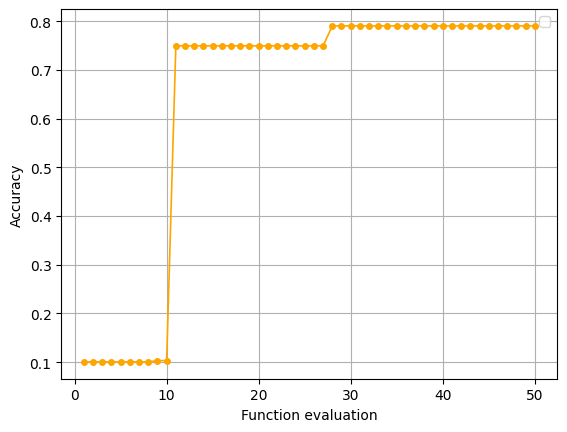

In [ ]:
Niter=50
r = range(1, Niter+1)
plt.plot(r, y_svm4, marker = 'o', linewidth=1.2, color='orange', markersize=4)

plt.xlabel('Function evaluation')
plt.ylabel('Accuracy')

plt.grid()
plt.legend()

# NN

## NN with 2 hyperparameters (2d)

In [ ]:
def DL(par1,par2):
  lr = par1
  bs = int(par2)


  mlp = MLPClassifier(hidden_layer_sizes=(40,), batch_size=bs,  #batch_size=32,
                      learning_rate_init=lr,
                    max_iter=150, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID)

  mlp.fit(X_train, y_train)

  return -mlp.score(X_test, y_test)

In [ ]:
y = BaMSOO_func(2, DL, min_range=[0.0002, 1], max_range=[2, 500], num_folds=6, max_depth=10, max_f_es=51, max_num_nodes=100, version=2, comparison_plot=True)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(



Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [ 0.139075 63.375   ]
	y = -0.7745
Number of nodes in tree:  54
Number of function evaluations:  51
Max depth reached:  5
Min depth reached:  2
Execution time:  36.93502330780029


In [ ]:
print(y)

[0.75775, 0.75775, 0.75775, 0.75775, 0.75775, 0.75775, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.771, 0.77325, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745, 0.7745]


## NN with 2 hyperparameters (2d) - max_iter=3000, m_training=2400

In [ ]:
#more data
m_training = 2400
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

In [ ]:
def DL2(par1,par2):
  lr = par1
  #layer_size = int(par[1])
  bs = int(par2)


  mlp = MLPClassifier(hidden_layer_sizes=(40,), batch_size=bs,  #batch_size=32,
                      learning_rate_init=lr,
                    max_iter=3000, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID)

  mlp.fit(X_train, y_train)

  return -mlp.score(X_test, y_test)

In [ ]:
y_nn2 = BaMSOO_func(2, DL2, min_range=[0.0002, 1], max_range=[2, 500], num_folds=6, max_depth=10, max_f_es=21, max_num_nodes=100, version=2, comparison_plot=True)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [  0.361275   208.91666667]
	y = -0.836
Number of nodes in tree:  23
Number of function evaluations:  21
Max depth reached:  4
Min depth reached:  2
Execution time:  54.55964231491089


In [ ]:
print(y_nn2)

[0.81825, 0.819, 0.819, 0.819, 0.819, 0.819, 0.819, 0.819, 0.82975, 0.82975, 0.82975, 0.82975, 0.836, 0.836, 0.836, 0.836, 0.836, 0.836, 0.836, 0.836]


## NN with 3 hyperparameters (5d)

In [ ]:
def NN_5D(par1, par2, par3, par4, par5):
  par = np.array([par1, par2, par3, par4, par5])

  idx=[1] #Round batch size
  idx_cat = [[2, 3, 4]] #categorical - solver

  par = [round(val) if i in idx else val for i, val in enumerate(par)]          # round to integer

  for sublist in idx_cat:                                                       # "round" to categorical
    max_value = max(par[i] for i in sublist)
    for i in range(len(par)):
        if i in sublist:
            par[i] = 1 if par[i] == max_value else 0

  lr, bs, *solver = par

  solver_choices = {0: 'lbfgs', 1: 'sgd', 2: 'adam'}                                                   # convert categorical variables to the SVM parameter
  index = solver.index(1)
  solver = solver_choices.get(index)

  mlp = MLPClassifier(hidden_layer_sizes=(40,), batch_size=bs,  #batch_size=32,
                      learning_rate_init=lr,
                    max_iter=150, alpha=1e-4, solver=solver,
                    tol=1e-4, random_state=ID)

  mlp.fit(X_train, y_train)

  return -mlp.score(X_test, y_test)

In [ ]:
idx=[1] #Round batch size
idx_cat = [[2, 3, 4]] #categorical - solver
bounds_par = [(0.0002,2),(1,500),(0,1),(0,1),(0,1)]
min_range = [item[0] for item in bounds_par]
max_range = [item[1] for item in bounds_par]

y_nn5 = BaMSOO_func(5, NN_5D, min_range=min_range, max_range=max_range, num_folds=2, max_depth=10, max_f_es=51, max_num_nodes=100, version=2, IDX=idx, IDX_CAT=idx_cat,  comparison_plot=True)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(



Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [  0.250175 125.75       0.25       0.75       0.25    ]
	y = -0.77
Number of nodes in tree:  78
Number of function evaluations:  51
Max depth reached:  7
Min depth reached:  5
Execution time:  46.140679597854614


In [ ]:
print(y_nn5)

[0.733, 0.733, 0.733, 0.733, 0.733, 0.733, 0.75125, 0.75125, 0.75125, 0.75125, 0.75125, 0.75125, 0.75125, 0.75125, 0.75125, 0.75125, 0.75125, 0.75125, 0.75125, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77]


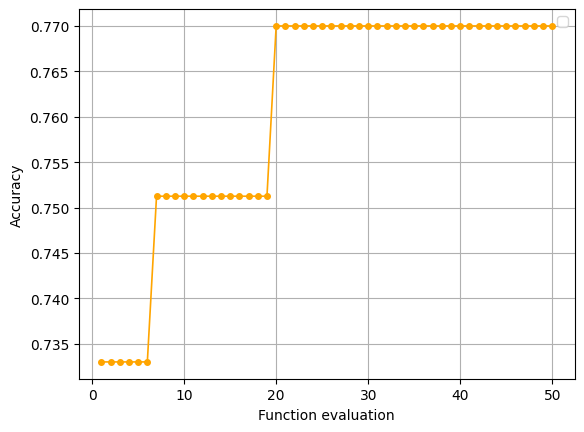

In [ ]:
Niter=50
r = range(1, Niter+1)
plt.plot(r, y_nn5, marker = 'o', linewidth=1.2, color='orange', markersize=4)

plt.xlabel('Function evaluation')
plt.ylabel('Accuracy')

plt.grid()
plt.legend()

## NN with 5 hyperparameters (7d)

In [ ]:
#more data
m_training = 2400
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

In [ ]:
def NN_7D(par1, par2, par3, par4, par5, par6, par7):
  par = np.array([par1, par2, par3, par4, par5, par6, par7])

  idx=[2,3] #Round batch size and #neurons
  idx_cat = [[4, 5, 6]] #categorical - solver

  par = [round(val) if i in idx else val for i, val in enumerate(par)]          # round to integer

  for sublist in idx_cat:                                                       # "round" to categorical
    max_value = max(par[i] for i in sublist)
    for i in range(len(par)):
        if i in sublist:
            par[i] = 1 if par[i] == max_value else 0

  lr, a, bs, neurons, *solver = par

  solver_choices = {0: 'lbfgs', 1: 'sgd', 2: 'adam'}                                                   # convert categorical variables to the SVM parameter
  index = solver.index(1)
  solver = solver_choices.get(index)

  mlp = MLPClassifier(hidden_layer_sizes=(neurons,), batch_size=bs,  #batch_size=32,
                      learning_rate_init=lr,
                    max_iter=300, alpha=a, solver=solver,
                    tol=1e-4, random_state=ID)

  mlp.fit(X_train, y_train)

  return -mlp.score(X_test, y_test)

In [ ]:
idx=[2,3] #Round batch size and #neurons
idx_cat = [[4, 5, 6]] #categorical - solver
bounds_par = [(0.0002,2),(0.00001, 0.1),(1,500),(5,50),(0,1),(0,1),(0,1)]
min_range = [item[0] for item in bounds_par]
max_range = [item[1] for item in bounds_par]

In [ ]:
y_nn7 = BaMSOO_func(7, NN_7D, min_range=min_range, max_range=max_range, num_folds=2, max_depth=10, max_f_es=21, max_num_nodes=100, version=2, IDX=idx, IDX_CAT=idx_cat,  comparison_plot=True)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  2

min:	x = [5.00150e-01 7.50025e-02 1.25750e+02 3.87500e+01 5.00000e-01 5.00000e-01
 5.00000e-01]
	y = -0.82025
Number of nodes in tree:  21
Number of function evaluations:  21
Max depth reached:  5
Min depth reached:  4
Execution time:  127.94750046730042


In [ ]:
y_nn7 = [0.8105, 0.8105, 0.8105, 0.81475, 0.81475, 0.81475, 0.81475, 0.81475, 0.81475, 0.81475, 0.81475, 0.81475, 0.81475, 0.82025, 0.82025, 0.82025, 0.82025, 0.82025, 0.82025, 0.82025]

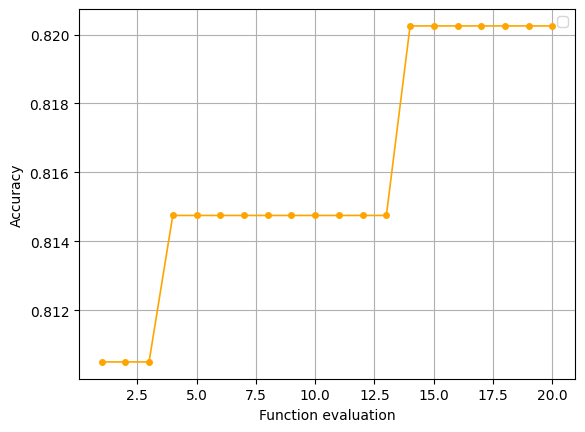

In [ ]:
Niter=20
r = range(1, Niter+1)
plt.plot(r, y_nn7, marker = 'o', linewidth=1.2, color='orange', markersize=4)

plt.xlabel('Function evaluation')
plt.ylabel('Accuracy')

plt.grid()
plt.legend()

### Test on different versions

In [ ]:
idx=[2,3] #Round batch size and #neurons
idx_cat = [[4, 5, 6]] #categorical - solver
bounds_par = [(0.0002,2),(0.00001, 0.1),(1,500),(5,50),(0,1),(0,1),(0,1)]
min_range = [item[0] for item in bounds_par]
max_range = [item[1] for item in bounds_par]
y1 = BaMSOO_func(7, NN_7D, min_range=min_range, max_range=max_range, num_folds=2, max_depth=10, max_f_es=21, max_num_nodes=100, version=1, IDX=idx, IDX_CAT=idx_cat,  comparison_plot=True)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  1

min:	x = [5.00150e-01 7.50025e-02 1.25750e+02 3.87500e+01 5.00000e-01 5.00000e-01
 5.00000e-01]
	y = -0.82025
Number of nodes in tree:  21
Number of function evaluations:  21
Max depth reached:  5
Min depth reached:  4
Execution time:  155.7640142440796


In [ ]:
y3 = BaMSOO_func(7, NN_7D, min_range=min_range, max_range=max_range, num_folds=2, max_depth=10, max_f_es=21, max_num_nodes=100, version=3, IDX=idx, IDX_CAT=idx_cat,  comparison_plot=True)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  3

min:	x = [5.00150e-01 7.50025e-02 1.25750e+02 3.87500e+01 5.00000e-01 5.00000e-01
 5.00000e-01]
	y = -0.82025
Number of nodes in tree:  21
Number of function evaluations:  21
Max depth reached:  5
Min depth reached:  4
Execution time:  114.17026662826538


In [ ]:
y4 = BaMSOO_func(7, NN_7D, min_range=min_range, max_range=max_range, num_folds=2, max_depth=10, max_f_es=21, max_num_nodes=100, version=4, IDX=idx, IDX_CAT=idx_cat,  comparison_plot=True)


Maximum number of function evaluation is reached

---------------------------------------------------------------------------------------------------------------------------------
version  4

min:	x = [5.00150e-01 7.50025e-02 1.25750e+02 3.87500e+01 5.00000e-01 5.00000e-01
 5.00000e-01]
	y = -0.82025
Number of nodes in tree:  21
Number of function evaluations:  21
Max depth reached:  5
Min depth reached:  4
Execution time:  114.06353640556335


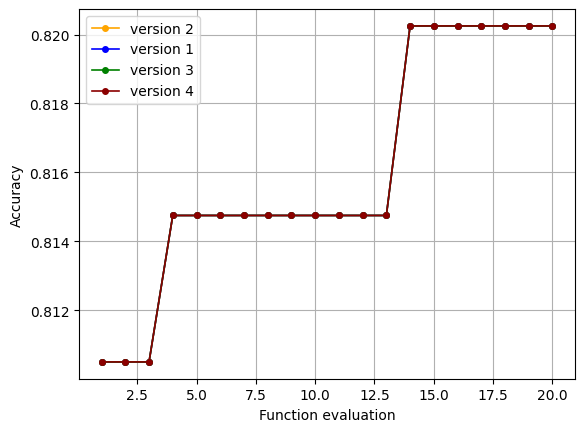

In [ ]:
Niter=20
r = range(1, Niter+1)
plt.plot(r, y_nn7, marker = 'o', linewidth=1.2, color='orange', markersize=4, label ='version 2')
plt.plot(r, y1, marker = 'o', linewidth=1.2, color='blue', markersize=4, label ='version 1')
plt.plot(r, y3, marker = 'o', linewidth=1.2, color='green', markersize=4, label ='version 3')
plt.plot(r, y4, marker = 'o', linewidth=1.2, color='darkred', markersize=4, label ='version 4')


plt.xlabel('Function evaluation')
plt.ylabel('Accuracy')

plt.grid()
plt.legend()

# Execution time comparison with BO
---

|        | SVM (2d) | SVM (5d) | NN (2d) | NN (5d) | NN (7d)|
|--------|----------|----------|---------|---------|--------|
| BaMSOO |  89s     |    83s   |   37s   |   46s   |  124s  |
| BO     | 143s     |   295s   |  108s   |  205s   |  360s  |

# Comments and final remarks

- Results depend strongly on the number of folds
- Version 2 appears to work the best although outside of simple problems there seems to be no difference in the results a part from the execution time
- We tested the algorithm on machine learning problems in order to confont it with the classic acquisation function based Bayesian optimization algorithm. But the value of a partition based BO, like BaMSOO, can be seen when dealing with multiscale problems.



# Bibliograph

[1] Z. Wang, B. Shakibi, L. Jin and N. de Freitas, “Bayesian Multi-Scale Optimistic Optimization” *AI and Statistics, pp. 1005–1014, 2014.*

[2] Abdullah Al-Dujaili and S. Suresh, "Analysis of the Bayesian Multi-Scale Optimistic Optimization on the CEC2016 and BBOB Testbeds" *2016 IEEE Congress on Evolutionary Computation(CEC), pp. 4988–4995, 2016, https://doi.org/10.1109/CEC.2016.7748319*

